# Analysis of yellow taxi dataset

In this workbook we will analyse yellow taxi trips in New York for years 2018 and 2019.

On the website [nyc.gov](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) one can find useful links for original datasets and other resources used in this notebook (like [dataset description](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)).


In the first part of this project we will try to get some insight into data. Then we will try to build some models that predict `fare_amount` on the basis of pick-up location and time.

**Note:** Before start, one should compile some auxiliary functions that are located at the end of this notebook.\
**Note:** Process of getting data is described in `get_data.ipynb` notebook.

## TOC
* [Importing packages and loading the data](#import-and-load)
* [First look at the data](#first-look)
    * [Data types](#data-types)
    * [Dates ranges](#dates-ranges)
    * [Categorical data](#categorical-data)
    * [Numerical data](#numerical-data)
* [Data analysis](#data-analysis)
    * [Preparing location data](#location-data)
    * [Top locations](#top-locations)
* [Predicting `fare_amount`](#predictions)
    * [Data preparation](#data-preparation)
    * [Models](#models)
        * [Random forest](#rf)
        * [Neural network](#nn)
* [Summary and recomedations](#summary)    
* [Appendix](#aux)    

# Importing packages and loading the data <a class="anchor" id="import-and-load"></a>

All package dependencies for this notebook can be found in `requiremnts.txt`.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import itertools
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

Let's set paths for our data and load all required files.

In [2]:
path = 'data/'
data_file = 'data/yellow_taxi_data.csv'
maps_file = 'data/long_lat.csv'

In [3]:
data = pd.read_csv(data_file)
maps = pd.read_csv(maps_file)
# coords column was parsed to string during writing to csv. 
# now we get it as list
maps['coords'] = maps['coords'].apply(lambda x: eval(x)) 

# First look at the data <a class="anchor" id="first-look"></a>

## Data types <a class="anchor" id="data-types"></a>

In this section we will look at the dataset and try to get some basic informations and remove obviuos outliers.
Let's check shape of the dataset.

In [4]:
no_of_rows, no_of_cols = data.shape
columns = data.columns
print(f'Number of rows: {no_of_rows} \nNumber of cols: {no_of_cols}')

Number of rows: 920000 
Number of cols: 18


And now we can see how the dataset looks like.

In [5]:
data.head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2.0,2001-01-01T00:01:48.000,2001-01-01T00:15:47.000,1.0,1.35,1.0,N,43,170,2.0,9.0,0.0,0.5,0.0,0.0,0.3,9.8,NaN
1,2.0,2001-01-01T00:01:48.000,2001-01-01T00:15:47.000,1.0,1.35,1.0,N,43,170,2.0,9.0,0.0,0.5,0.0,0.0,0.3,9.8,NaN
2,2.0,2001-01-01T00:02:26.000,2001-01-01T00:04:49.000,1.0,0.36,1.0,N,48,48,2.0,3.5,0.0,0.5,0.0,0.0,0.3,4.3,NaN
3,2.0,2001-01-01T00:02:26.000,2001-01-01T00:04:49.000,1.0,0.36,1.0,N,48,48,2.0,3.5,0.0,0.5,0.0,0.0,0.3,4.3,NaN
4,2.0,2001-01-01T00:05:12.000,2001-01-01T00:09:59.000,1.0,0.62,1.0,N,140,229,2.0,5.0,0.0,0.5,0.0,0.0,0.3,5.8,NaN


Let's print some informations about dataset.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920000 entries, 0 to 919999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   vendorid               919174 non-null  float64
 1   tpep_pickup_datetime   920000 non-null  object 
 2   tpep_dropoff_datetime  920000 non-null  object 
 3   passenger_count        919174 non-null  float64
 4   trip_distance          920000 non-null  float64
 5   ratecodeid             919174 non-null  float64
 6   store_and_fwd_flag     919174 non-null  object 
 7   pulocationid           920000 non-null  int64  
 8   dolocationid           920000 non-null  int64  
 9   payment_type           919174 non-null  float64
 10  fare_amount            920000 non-null  float64
 11  extra                  920000 non-null  float64
 12  mta_tax                920000 non-null  float64
 13  tip_amount             920000 non-null  float64
 14  tolls_amount           920000 non-nu

First of all, last dimension - `congestion_surcharge` is not presented in data from 2018, so we will remove it for data consistency.

In [7]:
del data['congestion_surcharge']

We can see that there are some missing values. Because not so many rows are affected, we will not perform any replacement and simply remove these rows.

In [8]:
data = data.loc[~data.isna().any(axis=1)]

There are also some issues with data types:
- `tpep_pickup_datetime` and `tpep_dropoff_datetime` should be parse to datetime format
<!-- - `vendorid`, `ratecodeid`, `store_and_fwd_flag`, `pulocationid`, `dolocationid`, `payment_type` are in fact categories not numerical data. -->

We can change above datatypes.

In [9]:
data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))
data['tpep_dropoff_datetime'] = data['tpep_dropoff_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))

## Dates ranges <a class="anchor" id="dates-ranges"></a>

Data should contains only rows for 2018 and 2019, however we can see that it is not the case, for example:

In [10]:
print(f'Minimal datetime: {min(data["tpep_pickup_datetime"])}')

Minimal datetime: 2001-01-01 00:01:48


So we will get rid off such rows.

In [11]:
data = data.loc[data.tpep_pickup_datetime.dt.year.isin([2018, 2019])]

In [12]:
data = data.loc[data.tpep_dropoff_datetime.dt.year.isin([2018, 2019])]

Now let's create some new columns with date / time informations. They might bring useful insight during futher analysis.

In [13]:
data['pickup_day'] = data['tpep_pickup_datetime'].dt.day_name()
data['pickup_date'] = data['tpep_pickup_datetime'].dt.date
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['dropoff_day'] = data['tpep_dropoff_datetime'].dt.day_name()
data['dropoff_date'] = data['tpep_dropoff_datetime'].dt.date
data['dropoff_hour'] = data['tpep_dropoff_datetime'].dt.hour

## Categorical data <a class="anchor" id="categorical-data"></a>

Let's quickly go through categorical data. Here we can get rid of classes that should not be presented (according to dataset documentation).

### Vendor id

In [14]:
data['vendorid'].value_counts()

2.0    550087
1.0    363427
4.0      3754
Name: vendorid, dtype: int64

In [15]:
data = data.loc[data['vendorid'].isin([1, 2])]

### Rate code id

In [16]:
data['ratecodeid'].value_counts()

1.0     884803
2.0      22159
5.0       4257
3.0       1581
4.0        682
99.0        24
6.0          8
Name: ratecodeid, dtype: int64

As expected, most trips are 'standard' (`ratecodeid = 1`). But trips to or from JFK Airport are also popular (`ratecodeid = 2`). These trips have fixed fare amount so it is important to get this variable into account. We can see that fare amount for JFK is fixed in the cell below.

There are also some wrong values: 99.

In [17]:
data.query('ratecodeid == 2').groupby(by=['ratecodeid', 'fare_amount']).size()

ratecodeid  fare_amount
2.0         -52.00            80
             0.00              2
             2.50              4
             10.50             1
             20.00             2
             52.00         22065
             68.56             1
             73.06             3
             77.86             1
dtype: int64

In [18]:
data = data.loc[data['ratecodeid'].isin([1, 2, 3, 4, 5, 6])]
data = data.loc[~( (data['ratecodeid'] == 2) & (data['fare_amount'] != 52) )]

Let's also convert `ratecodeid` to `sting` as it is a categorical variable.

In [19]:
data['ratecodeid'] = data['ratecodeid'].astype(int).astype(str)

### Store and fwd flag

This feature indicates if data about trip was stored in vehicle memory due to lack on connection with server.

In [20]:
data['store_and_fwd_flag'].value_counts()

N    907412
Y      5984
Name: store_and_fwd_flag, dtype: int64

### Payment type

Most payments were done with credit card (`payment_type = 1`) or cash (`payment_type = 2`). In some cases there was no charge or dispute.

In [21]:
data['payment_type'].value_counts()

1.0    646559
2.0    260449
3.0      4773
4.0      1615
Name: payment_type, dtype: int64

## Numerical data <a class="anchor" id="numerical-data"></a>

Now let's move to numerical columns. In this section we will try to get some informations about numerical columns and remove rows that are outliers.

In [22]:
data.describe()

,vendorid,passenger_count,trip_distance,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_hour,dropoff_hour
count,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000
mean,1.602130,1.590930,2.946103,162.910255,161.148970,1.300899,13.093656,0.651757,0.496658,2.012570,0.348288,0.299256,17.419081,14.441215,14.537821
std,0.489459,1.235206,3.805657,66.181098,70.678102,0.481060,11.938457,0.931009,0.046729,2.714685,1.908940,0.020277,14.713907,6.151961,6.231711
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-400.000000,-3.500000,-0.500000,-88.880000,-18.620000,-0.300000,-320.240000,0.000000,0.000000
25%,1.000000,1.000000,0.980000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,9.360000,10.000000,10.000000
50%,2.000000,1.000000,1.610000,162.000000,162.000000,1.000000,9.500000,0.500000,0.500000,1.560000,0.000000,0.300000,12.960000,16.000000,16.000000
75%,2.000000,2.000000,3.020000,233.000000,233.000000,2.000000,14.500000,1.000000,0.500000,2.660000,0.000000,0.300000,18.960000,20.000000,20.000000
max,2.000000,9.000000,129.280000,265.000000,265.000000,4.000000,950.000000,7.000000,3.300000,400.000000,777.280000,1.000000,996.100000,23.000000,23.000000


We can notice some errors:
- `passenger_count = 0`
- `trip_distance = 0`
- `fare_amount < 0`
- `extra < 0`
- `mta_tax < 0`
- `tip_amount < 0` (Note! Only tips from creditcards - no cash included)
- `tolls_amount < 0`
- `improvement_surcharge < 0`
- `total_amount < 0`

We will remove rows with such values. There are also rows with very high values - we will look at them later on.

In [23]:
query = '''\
passenger_count <= 0 or trip_distance <= 0 or fare_amount < 0 \
or extra < 0 or mta_tax < 0 or tip_amount < 0 or tolls_amount < 0 \
or improvement_surcharge < 0 or total_amount < 0'''

In [24]:
data = data.query(f'~({query})').copy()

Let's see how numerical data looks after removing some faulty rows.

In [25]:
data.describe()

,vendorid,passenger_count,trip_distance,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_hour,dropoff_hour
count,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000
mean,1.610189,1.613103,2.971036,162.870025,161.013346,1.296096,13.025396,0.643167,0.498430,2.006979,0.346011,0.299964,17.347807,14.444212,14.541951
std,0.487708,1.231754,3.814280,66.122044,70.628966,0.472759,11.271676,0.918595,0.028186,2.622147,1.905074,0.003281,14.096948,6.150453,6.230104
min,1.000000,1.000000,0.010000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,9.360000,10.000000,10.000000
50%,2.000000,1.000000,1.630000,162.000000,162.000000,1.000000,9.500000,0.500000,0.500000,1.560000,0.000000,0.300000,12.960000,16.000000,16.000000
75%,2.000000,2.000000,3.050000,233.000000,233.000000,2.000000,14.500000,1.000000,0.500000,2.660000,0.000000,0.300000,18.960000,20.000000,20.000000
max,2.000000,9.000000,129.280000,265.000000,265.000000,4.000000,426.000000,7.000000,3.300000,331.650000,777.280000,0.300000,996.100000,23.000000,23.000000


Data looks much better now but there are still some issues. Let's dig a bit deeper.

### Far amount, total amount and trip distance

We can plot some graphs with `fare_amount` vs `trip_distance` and `fare_amount` vs `total_amount`.

<AxesSubplot:xlabel='total_amount', ylabel='fare_amount'>

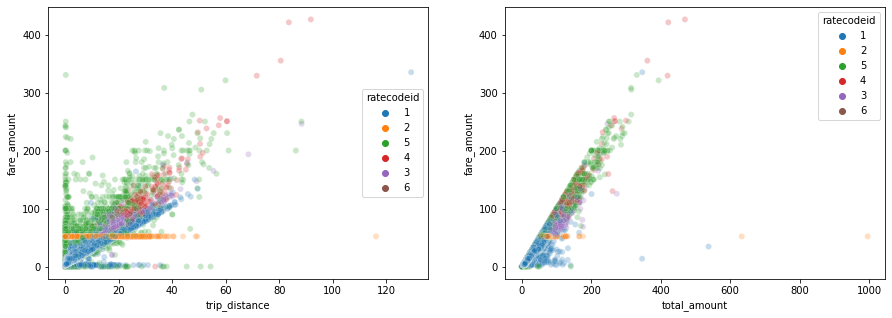

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x='trip_distance', y='fare_amount', data=data, hue = 'ratecodeid', ax=ax[0], alpha=0.25)
sns.scatterplot(x='total_amount', y='fare_amount', data=data, hue = 'ratecodeid', ax=ax[1], alpha=0.25)

There should be positive correlations in above plots. In general it is the case. However, we can see some outliers. \
Additionally, on the first plot there ara some clusters visible. Let's investigate them.

Blue color (`ratecodeid = 1`) indicates standard trips. And with standard trips, correlation between `trip_distance` and `fare_amount` is linear.

Yellow color (`ratecodeid = 2`) indicates trips to/from JFK Airport. These trips have fixed fare amount. And we can see that for short distances such trips are better paid than standard one.

Then comes green color (`ratecodeid = 5`) which stands for negotiated fare. These points are usually placed higher than standard trips: for the same trip distance, fare amount is higher.

We can look at some most extreme points.

In [30]:
data.query('fare_amount > 290 or trip_distance > 70')

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_day,pickup_date,pickup_hour,dropoff_day,dropoff_date,dropoff_hour
16566,2.0,2018-11-15 08:56:48,2018-11-15 10:59:04,1.0,88.33,3,N,50,265,2.0,246.00,0.0,0.0,0.00,0.00,0.3,246.30,Thursday,2018-11-15,8,Thursday,2018-11-15,10
49349,2.0,2018-12-11 08:17:09,2018-12-11 10:16:41,1.0,80.54,4,N,132,265,1.0,355.00,0.0,0.5,0.00,5.76,0.3,361.56,Tuesday,2018-12-11,8,Tuesday,2018-12-11,10
71402,1.0,2018-12-26 00:02:54,2018-12-26 01:44:24,1.0,86.20,5,N,264,264,1.0,200.00,0.0,0.0,0.00,0.00,0.3,200.30,Wednesday,2018-12-26,0,Wednesday,2018-12-26,1
271768,2.0,2018-05-05 21:34:01,2018-05-05 22:26:36,1.0,50.86,5,N,132,265,1.0,305.00,0.0,0.0,10.10,0.00,0.3,315.40,Saturday,2018-05-05,21,Saturday,2018-05-05,22
294686,2.0,2018-05-15 18:26:16,2018-05-15 18:26:21,1.0,0.20,5,N,264,264,1.0,330.33,0.0,0.5,0.00,0.00,0.3,331.13,Tuesday,2018-05-15,18,Tuesday,2018-05-15,18
299704,2.0,2018-05-18 20:19:53,2018-05-18 23:13:17,3.0,129.28,1,N,48,265,2.0,335.00,0.5,0.5,0.00,10.50,0.3,346.80,Friday,2018-05-18,20,Friday,2018-05-18,23
332756,2.0,2018-06-12 13:19:15,2018-06-12 13:55:36,5.0,116.16,2,N,145,132,2.0,52.00,0.0,0.5,0.00,0.00,0.3,52.80,Tuesday,2018-06-12,13,Tuesday,2018-06-12,13
373280,2.0,2018-07-08 15:05:06,2018-07-08 16:25:06,1.0,71.58,4,N,132,265,1.0,329.00,0.0,0.5,69.96,20.00,0.3,419.76,Sunday,2018-07-08,15,Sunday,2018-07-08,16
403756,2.0,2018-07-27 09:47:28,2018-07-27 11:56:35,1.0,88.30,5,N,132,265,1.0,250.00,0.0,0.5,51.31,5.76,0.3,307.87,Friday,2018-07-27,9,Friday,2018-07-27,11
661265,2.0,2019-04-22 23:20:43,2019-04-23 00:31:29,1.0,59.88,5,N,138,265,1.0,321.00,0.0,0.0,50.00,22.74,0.3,394.04,Monday,2019-04-22,23,Tuesday,2019-04-23,0


Such trips are really rare and with extreme values so we can remove them - it will result in more consistent data.

But before we do that, let's look at outliers from the second picture.

In [31]:
data.query('fare_amount < 100 and total_amount > 300')

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_day,pickup_date,pickup_hour,dropoff_day,dropoff_date,dropoff_hour
33117,2.0,2018-11-30 20:36:01,2018-11-30 20:47:29,1.0,3.88,1,N,87,107,1.0,13.5,0.5,0.5,331.65,0.00,0.3,346.45,Friday,2018-11-30,20,Friday,2018-11-30,20
251501,1.0,2018-04-23 10:07:07,2018-04-23 11:01:58,1.0,19.20,2,N,231,132,3.0,52.0,0.0,0.5,166.02,777.28,0.3,996.10,Monday,2018-04-23,10,Monday,2018-04-23,11
838602,1.0,2019-01-25 17:21:05,2019-01-25 18:23:21,1.0,17.50,2,N,264,264,2.0,52.0,4.5,0.5,0.00,576.00,0.3,633.30,Friday,2019-01-25,17,Friday,2019-01-25,18
919509,1.0,2019-02-06 10:11:13,2019-02-06 10:50:52,1.0,10.50,1,N,50,138,3.0,34.5,2.5,0.5,0.00,500.05,0.3,537.85,Wednesday,2019-02-06,10,Wednesday,2019-02-06,10


There are some huge tolls and/or tips. As above, such values are possible but very rare and extreme.

So let's clean the data.

In [32]:
data = data.query('~(fare_amount < 100 and total_amount > 300) and ~(fare_amount > 290 or trip_distance > 70)')

### Passenger count

Let's plot some basic graphs.

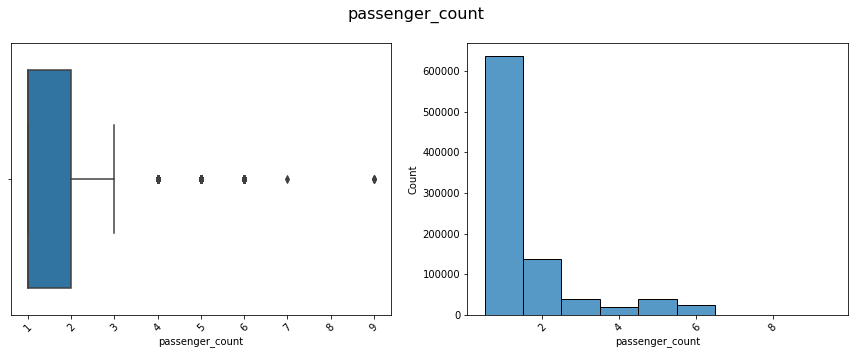

In [33]:
simple_box_plot_and_hisotgram(data, column='passenger_count', figsize=(15, 5), discrete=True, kde=False, bins='auto')

Defintely, one-passenger trips are the most popular.

There are some outliers. Let's count values.

In [34]:
data.groupby('passenger_count').size()

passenger_count
1.0    636845
2.0    137071
3.0     38395
4.0     18280
5.0     40138
6.0     23837
7.0         1
9.0         3
dtype: int64

Values above 6 are extremaly rare.

In [35]:
data = data.query('passenger_count <= 6')

# Data analysis <a class="anchor" id="data-analysis"></a>

In this section we will do some more detailed analysis. We will try to find out during which part of a day traffic is highest. We will also plot some maps to show best locations.

## Time

First, let's check number of trips per weekday and hour.

In [36]:
data_agg = data.groupby(by = ['pickup_day', 'pickup_hour'], as_index=False).agg(
    number_of_trips = ('fare_amount', 'count'),
    average_fare_amount = ('fare_amount', np.mean),
    total_fare_amount = ('fare_amount', np.sum)
)

Text(0.5, 1.0, 'Total fare amount per hour')

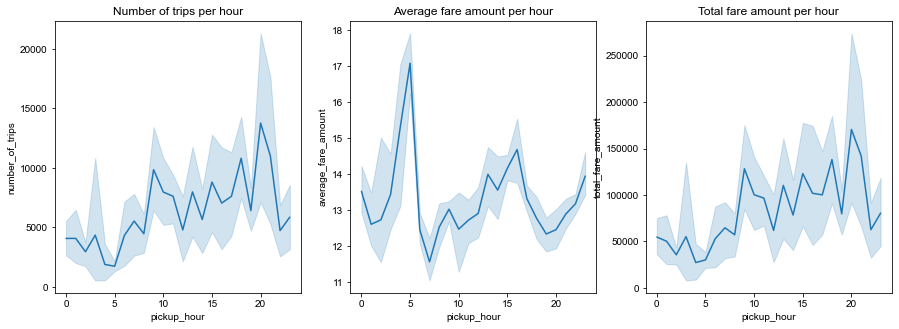

In [37]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
sns.set_theme(style="darkgrid")

sns.lineplot(ax=ax[0], x='pickup_hour', y='number_of_trips', data=data_agg)
ax[0].set_title('Number of trips per hour')

sns.lineplot(ax=ax[1], x='pickup_hour', y='average_fare_amount', data=data_agg)
ax[1].set_title('Average fare amount per hour')

sns.lineplot(ax=ax[2], x='pickup_hour', y='total_fare_amount', data=data_agg)
ax[2].set_title('Total fare amount per hour')

We can see that number of trips increases rapidly in the morning (between 5 and 10 a.m.); then it is almost stable and again increases in the afternoon (about 8 p.m.). Plot of total fare amount looks similar. But average fare amount is definitely highest in the morning.

## Preparing location data <a class="anchor" id="location-data"></a>

Now, we can add some informations about locations. File was prepared earlier in the notebook `maps.ipynb`.

In [38]:
maps.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,coords,x,y
0,1,0.116357,0.000782,Newark Airport,1,EWR,"[(933100.9183527103, 192536.08569720192), (933...",9.359210e+05,190798.948561
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"[(1033269.2435912937, 172126.0078125), (103343...",1.034880e+06,162357.340842
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"[(1026308.7695066631, 256767.6975403726), (102...",1.026705e+06,254200.631614
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"[(992073.4667968601, 203714.07598876953), (992...",9.911216e+05,202996.758991
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"[(935843.3104932606, 144283.33585065603), (936...",9.315082e+05,142146.593123


We can join this data with main dataset using `OBJECTID`.

First, let's add informations for pick-up location.

In [39]:
data = data.merge(maps[['OBJECTID', 'zone', 'borough', 'x', 'y']],
                  how = 'left',
                  left_on = 'pulocationid', right_on = 'OBJECTID',
                  validate = 'm:1')

del data['OBJECTID']
data.rename(columns = {'zone': 'pickup_zone', 'borough': 'pickup_borough', 'x': 'pickup_x', 'y': 'pickup_y'}, inplace=True)

And now for drop off.

In [40]:
data = data.merge(maps[['OBJECTID', 'zone', 'borough', 'x', 'y']],
                  how = 'left',
                  left_on = 'dolocationid', right_on = 'OBJECTID',
                  validate = 'm:1')

del data['OBJECTID']
data.rename(columns = {'zone': 'dropoff_zone', 'borough': 'dropoff_borough', 'x': 'dropoff_x', 'y': 'dropoff_y'}, inplace=True)

We can notice that in some cases location data are not presented. It is due to a fact that in shapefile there are no such locations (for example 264 or 265).

In [41]:
data.loc[data.isna().any(axis=1)].head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_day,pickup_date,pickup_hour,dropoff_day,dropoff_date,dropoff_hour,pickup_zone,pickup_borough,pickup_x,pickup_y,dropoff_zone,dropoff_borough,dropoff_x,dropoff_y
49,2.0,2018-01-01 00:00:51,2018-01-01 00:14:31,1.0,6.63,1,N,264,264,1.0,20.0,0.5,0.5,5.32,0.0,0.3,26.62,Monday,2018-01-01,0,Monday,2018-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,2.0,2018-01-01 00:00:59,2018-01-01 00:02:40,6.0,0.33,1,N,264,264,1.0,3.5,0.5,0.5,0.96,0.0,0.3,5.76,Monday,2018-01-01,0,Monday,2018-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,2.0,2018-01-01 00:01:07,2018-01-01 00:01:10,2.0,0.06,5,N,264,113,1.0,15.0,0.0,0.0,0.00,0.0,0.3,15.30,Monday,2018-01-01,0,Monday,2018-01-01,0,NaN,NaN,NaN,NaN,Greenwich Village North,Manhattan,985856.794349,205930.197075
77,1.0,2018-01-01 00:01:18,2018-01-01 00:10:26,1.0,1.80,1,N,264,264,2.0,8.5,0.5,0.5,0.00,0.0,0.3,9.80,Monday,2018-01-01,0,Monday,2018-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,1.0,2018-01-01 00:01:26,2018-01-01 00:09:18,1.0,1.00,1,N,264,264,1.0,6.5,0.5,0.5,1.30,0.0,0.3,9.10,Monday,2018-01-01,0,Monday,2018-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Because it is still relatively small part of a dataset we will remove these rows.

In [42]:
data = data.loc[~data.isna().any(axis=1)]

Now we can also get rid off no longer needed features: `pulocationid` and `dolocationid`.

In [43]:
del data['pulocationid']
del data['dolocationid']

### Plot a map of NYC

We are ready to plot a map of NYC!\
(Function `borough_map` is define at the bottom of this notebook).

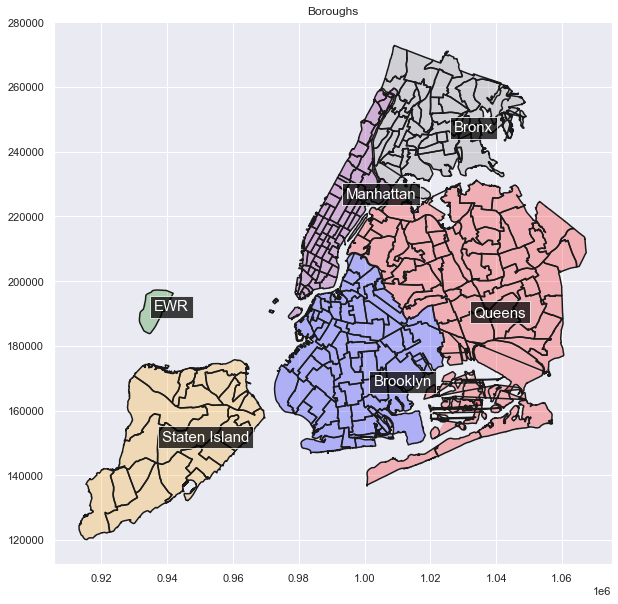

In [44]:
fig, ax = plt.subplots(1, figsize = (10, 10))
borough_map("Boroughs", maps, ax)

## Top locations <a class="anchor" id="top-locations"></a>

In this section we will try to find out which locations are best in terms of:
- number of trips
- fare amounts 
- fare amount by mile

First, let's add one more variable to out dataset. It will be fare amount by one mile of a trip. It will get some more informations about best trips.

In [45]:
data['fare_amount_by_mile'] = data['fare_amount'] / data['trip_distance']

Now we can calculate some statistics over boroughs. We will use median (not mean) to decrease infuence of possible outliers.

In [46]:
# Statisitcs for pick-up location by borough.
pickup = data.groupby(by=['pickup_borough'], as_index=False).agg(
    median_fare_amount=('fare_amount', np.median),
    median_fare_amount_by_trip=('fare_amount_by_mile', np.median),
    median_trip_distance=('trip_distance', np.median),
    total_number_of_trips=('fare_amount', 'count'),
)


# The same calculatiions with drop-off locations.
dropoff = data.groupby(by=['dropoff_borough'], as_index=False).agg(
    median_fare_amount=('fare_amount', np.median),
    median_fare_amount_by_trip=('fare_amount_by_mile', np.median),
    median_trip_distance=('trip_distance', np.median),
    total_number_of_trips=('fare_amount', 'count'),
)


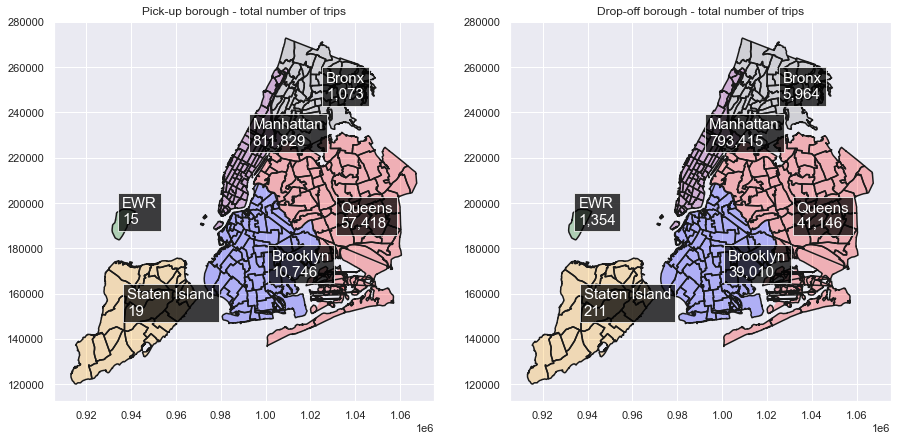

In [47]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
borough_map("Pick-up borough - total number of trips", 
            df = maps, 
            ax = ax[0],
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in pickup[['pickup_borough', 'total_number_of_trips']].itertuples()})
borough_map("Drop-off borough - total number of trips", 
            df = maps, 
            ax = ax[1],
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in dropoff[['dropoff_borough', 'total_number_of_trips']].itertuples()})


These maps indicates that greatest traffic is in Manhattan. Number of trips is much higher than in remaining boroughs.

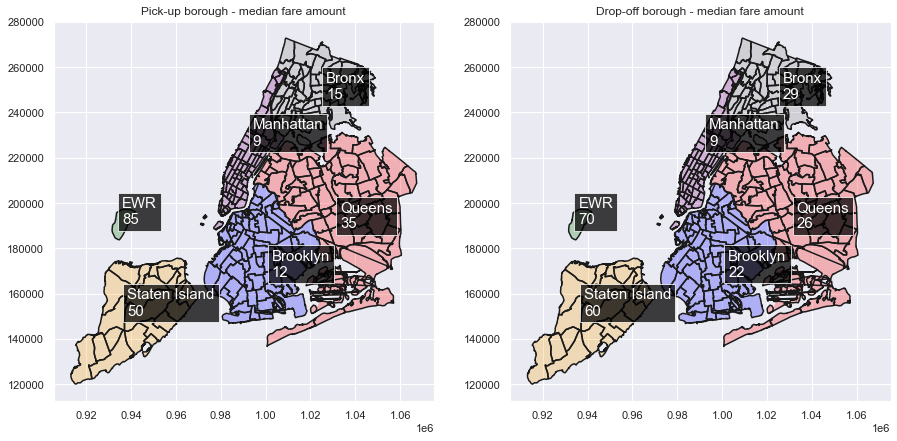

In [48]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))

borough_map("Pick-up borough - median fare amount", 
            df = maps, 
            ax = ax[0], 
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in pickup[['pickup_borough', 'median_fare_amount']].itertuples()})
borough_map("Drop-off borough - median fare amount", 
            df = maps, 
            ax = ax[1], 
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in dropoff[['dropoff_borough', 'median_fare_amount']].itertuples()})

plt.show()

However, Manhattan is not in the first place in terms of typical fare amount. Values for Queens is much higher.
Other boroughs are not really representative - there is not enough data points to make some conclusions.

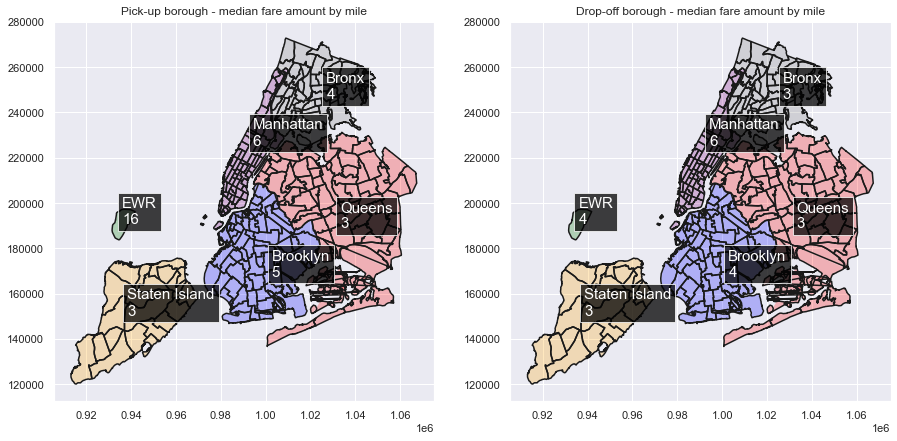

In [49]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))

borough_map("Pick-up borough - median fare amount by mile", 
            df = maps, 
            ax = ax[0],
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in pickup[['pickup_borough', 'median_fare_amount_by_trip']].itertuples()})


borough_map("Drop-off borough - median fare amount by mile", 
            df = maps, 
            ax = ax[1],
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in dropoff[['dropoff_borough', 'median_fare_amount_by_trip']].itertuples()})


Even though typical fare amount by trip in Manhattan is not high, fare amouny by mile is highest. It may be caused by the fact that trips in Manhattan are shorter.

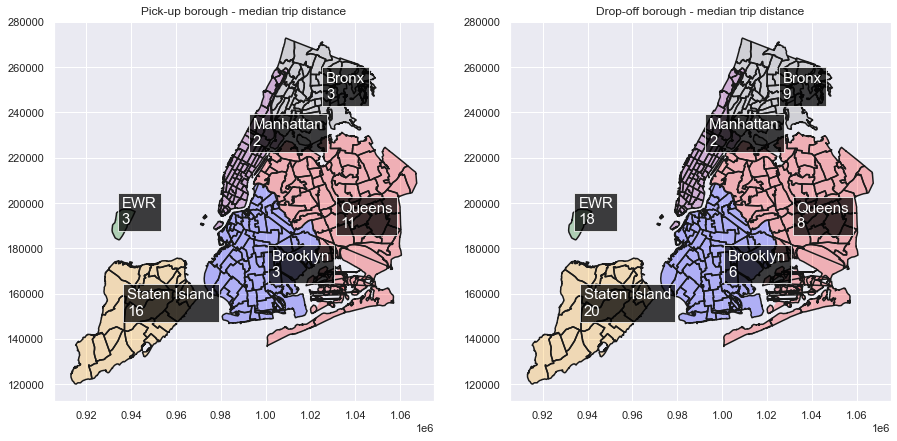

In [50]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
borough_map("Pick-up borough - median trip distance", 
            df = maps, 
            ax = ax[0],
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in pickup[['pickup_borough', 'median_trip_distance']].itertuples()})
borough_map("Drop-off borough - median trip distance", 
            df = maps, 
            ax = ax[1],
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in dropoff[['dropoff_borough', 'median_trip_distance']].itertuples()})



In this plot we can see that trips that start in Manhattan are short indeed. That is the reason for high fare amount by mile.

### Common destinations

Let's also find out what are common destinations. We can aggregate data by pick-up and drop-off borough and see what destinations are most frequent for each borough.\
We will make plots only for top 3 boroughs (by number of pick-ups): Manhattan, Queens and Brooklyn.

In [51]:
data_agg = data.groupby(by = ['pickup_borough', 'dropoff_borough'], as_index=False).size()

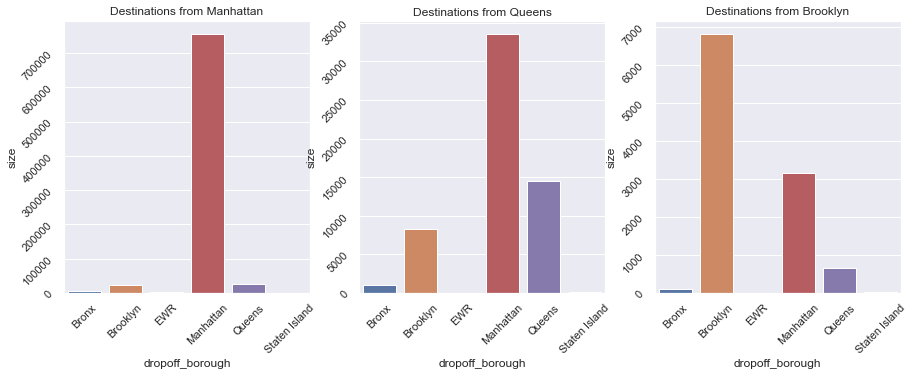

In [52]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for num, name in enumerate(['Manhattan', 'Queens', 'Brooklyn']):
    ax[num].tick_params(labelrotation=45)
    ax[num].set_title(f'Destinations from {name}')
    sns.barplot(x='dropoff_borough', y='size', data=data_agg.query(f'pickup_borough == "{name}"'), ax=ax[num])

plt.show()

We can see that for trips that started in:
- Manhattan - most trips ends in Manhattan
- Queens - most trip also ends in Manhattan
- Brooklyn - most trips ends in Brooklyn but Manhattan is second destination

These graphs for Manhattan and Queens might be an explanation of high fare amount by mile in Manhattan and low in Queens. And also for the fact that fare amount is higher in Quuens - trips from Queens to Manhattan are longer than trips inside borders of Manhattan.

# Predicting `fare_amount` <a class="anchor" id="predictions"></a>

We will try to build models to predict `fare_amount` on the basis of pick-up location and time.\
In this section we will:
- change categorical data into numerical using one-hot encoder
- remove outliers. As for now we tried to look into a data and remove outliers manually. But before modeling we will perform some multi-dimensional outliers detection. We will use Isolation Forest algorithm. It can be easly applied to high-dimentinal data
- split data into train and test sets and standarize them
- finally we will check errors in predictions

We will try two approaches:
- random forest with grid search using `sklearn`
- neural network using `tensorflow`

## Data preparation <a class="anchor" id="data-preparation"></a>

Let's define predicators.

In [54]:
Y = 'fare_amount'
X_numerical = ['pickup_hour', 'pickup_x', 'pickup_y', 'fare_amount_by_mile']
X_categorical = ['ratecodeid', 'pickup_day', 'pickup_zone', 'pickup_borough']

In [55]:
X = data[[Y] + X_numerical + X_categorical].copy()

### One-hot encoding for categorical data

We have to convert catgeorical data to numerical. We will use one-hot encoder.

In [56]:
X.head()

,fare_amount,pickup_hour,pickup_x,pickup_y,fare_amount_by_mile,ratecodeid,pickup_day,pickup_zone,pickup_borough
0,27.0,0,9.941451e+05,214631.345101,2.954048,1,Monday,Sutton Place/Turtle Bay North,Manhattan
1,7.5,0,9.840966e+05,211884.539346,5.514706,1,Monday,East Chelsea,Manhattan
2,20.5,0,9.948744e+05,201467.320414,3.360656,1,Monday,Williamsburg (North Side),Brooklyn
3,5.5,0,9.961204e+05,223550.620290,5.555556,1,Monday,Upper East Side North,Manhattan
4,13.5,0,1.005347e+06,192662.343965,3.750000,1,Monday,Bushwick South,Brooklyn


In [57]:
X = pd.get_dummies(X)

In [58]:
X.head()

,fare_amount,pickup_hour,pickup_x,pickup_y,fare_amount_by_mile,ratecodeid_1,ratecodeid_2,ratecodeid_3,ratecodeid_4,ratecodeid_5,ratecodeid_6,pickup_day_Friday,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,pickup_zone_Allerton/Pelham Gardens,pickup_zone_Alphabet City,pickup_zone_Arden Heights,pickup_zone_Arrochar/Fort Wadsworth,pickup_zone_Astoria,pickup_zone_Astoria Park,pickup_zone_Auburndale,pickup_zone_Baisley Park,pickup_zone_Bath Beach,pickup_zone_Battery Park,pickup_zone_Battery Park City,pickup_zone_Bay Ridge,pickup_zone_Bay Terrace/Fort Totten,pickup_zone_Bayside,pickup_zone_Bedford,pickup_zone_Bedford Park,pickup_zone_Bellerose,pickup_zone_Belmont,pickup_zone_Bensonhurst East,pickup_zone_Bensonhurst West,pickup_zone_Bloomfield/Emerson Hill,pickup_zone_Bloomingdale,pickup_zone_Boerum Hill,pickup_zone_Borough Park,pickup_zone_Breezy Point/Fort Tilden/Riis Beach,pickup_zone_Briarwood/Jamaica Hills,pickup_zone_Brighton Beach,pickup_zone_Broad Channel,pickup_zone_Bronx Park,pickup_zone_Bronxdale,pickup_zone_Brooklyn Heights,pickup_zone_Brooklyn Navy Yard,pickup_zone_Brownsville,pickup_zone_Bushwick North,pickup_zone_Bushwick South,pickup_zone_Cambria Heights,pickup_zone_Canarsie,pickup_zone_Carroll Gardens,pickup_zone_Central Harlem,pickup_zone_Central Harlem North,pickup_zone_Central Park,pickup_zone_Chinatown,pickup_zone_Claremont/Bathgate,pickup_zone_Clinton East,pickup_zone_Clinton Hill,pickup_zone_Clinton West,pickup_zone_Co-Op City,pickup_zone_Cobble Hill,pickup_zone_College Point,pickup_zone_Columbia Street,pickup_zone_Coney Island,pickup_zone_Corona,pickup_zone_Crotona Park,pickup_zone_Crotona Park East,pickup_zone_Crown Heights North,pickup_zone_Crown Heights South,pickup_zone_Cypress Hills,pickup_zone_DUMBO/Vinegar Hill,pickup_zone_Douglaston,pickup_zone_Downtown Brooklyn/MetroTech,pickup_zone_Dyker Heights,pickup_zone_East Chelsea,pickup_zone_East Concourse/Concourse Village,pickup_zone_East Elmhurst,pickup_zone_East Flatbush/Farragut,pickup_zone_East Flatbush/Remsen Village,pickup_zone_East Flushing,pickup_zone_East Harlem North,pickup_zone_East Harlem South,pickup_zone_East New York,pickup_zone_East New York/Pennsylvania Avenue,pickup_zone_East Tremont,pickup_zone_East Village,pickup_zone_East Williamsburg,pickup_zone_Eastchester,pickup_zone_Elmhurst,pickup_zone_Elmhurst/Maspeth,pickup_zone_Eltingville/Annadale/Prince's Bay,pickup_zone_Erasmus,pickup_zone_Far Rockaway,pickup_zone_Financial District North,pickup_zone_Financial District South,pickup_zone_Flatbush/Ditmas Park,pickup_zone_Flatiron,pickup_zone_Flatlands,pickup_zone_Flushing,pickup_zone_Flushing Meadows-Corona Park,pickup_zone_Fordham South,pickup_zone_Forest Hills,pickup_zone_Forest Park/Highland Park,pickup_zone_Fort Greene,pickup_zone_Fresh Meadows,pickup_zone_Freshkills Park,pickup_zone_Garment District,pickup_zone_Glen Oaks,pickup_zone_Glendale,pickup_zone_Governor's Island/Ellis Island/Liberty Island,pickup_zone_Gowanus,pickup_zone_Gramercy,pickup_zone_Gravesend,pickup_zone_Green-Wood Cemetery,pickup_zone_Greenpoint,pickup_zone_Greenwich Village North,pickup_zone_Greenwich Village South,pickup_zone_Hamilton Heights,pickup_zone_Hammels/Arverne,pickup_zone_Heartland Village/Todt Hill,pickup_zone_Highbridge,pickup_zone_Highbridge Park,pickup_zone_Hillcrest/Pomonok,pickup_zone_Hollis,pickup_zone_Homecrest,pickup_zone_Howard Beach,pickup_zone_Hudson Sq,pickup_zone_Hunts Point,pickup_zone_Inwood,pickup_zone_Inwood Hill Park,pickup_zone_JFK Airport,pickup_zone_Jackson Heights,pickup_zone_Jamaica,pickup_zone_Jamaica Bay,pickup_zone_Jamaica Estates,pickup_zone_Kensington,pickup_zone_Kew Gardens,pickup_zone_Kew Gardens Hills,pickup_zone_Kingsbridge Heights,pickup_zone_Kips Bay,pickup_zone_LaGuardia Airport,pickup_zone_Laurelton,pickup_zone_Lenox Hill East,pickup_zone_Lenox Hill West,pickup_zone_Lincoln Square East,pickup_zone_Lincoln Square West,pickup_zone_Little Italy/NoLiTa,pickup_

### IsolationForest for outliers detection

Here we will apply Isolation Forest to detect anomalies in our data.

In [63]:
from sklearn.ensemble import IsolationForest

In [64]:
isolation_forest_model = IsolationForest(random_state=44).fit(X)

In [65]:
X_outliers = isolation_forest_model.predict(X)

In [66]:
sum(X_outliers==-1)

0

No outliers were detected. We will left data unchanged.

### Splitting data into train and test sets

We will split the data into two sets. 2/3 will be for learning and 1/3 for testing.

We will use `sklearn` package.

In [66]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

Let's define feature columns.

In [67]:
features = list(X.columns)
features.remove(Y)

And now we can split our dataset.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X[features], X[Y], test_size=0.33, random_state=44)

In [69]:
print('Training set:', X_train.shape)
print('Training labels:', y_train.shape)
print('Testing set:', X_test.shape)
print('Testing labels:', y_test.shape)

Training set: (590337, 268)
Training labels: (590337,)
Testing set: (290763, 268)
Testing labels: (290763,)


We can delete temporary data frame `X`.

In [70]:
del X

### Data standarization

Let's standarize our data. Again we will use `sklearn` package. First, we will fit scaler to train data and then apply it to train and test sets.

In [71]:
scaler = preprocessing.RobustScaler().fit(X_train)

In [72]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Models <a class="anchor" id="models"></a>

Our data are prepared to build some models. We will try two approaches.
- random forest from `sklearn`
- neural network from `tensorflow`

### Random forest  <a class="anchor" id="rf"></a>

First we will try to build random forest.

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

Let's define and fit model. We will use grid search in order to increase chances of finding proper parameters.\
Then we can make prediction on test set.

In [74]:
n_estimators = [50, 100, 200]
max_features = ['auto', 'sqrt']
max_depth = [10, 25, 50]
cv = 3

grid_search_params = {'n_estimators': n_estimators,
                      'max_features': max_features,
                      'max_depth': max_depth}

In [75]:
t0 = time.time()


rf_model = RandomForestRegressor(random_state=44)
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=grid_search_params,
                           scoring='neg_mean_absolute_error',
                           cv=cv, 
                           verbose=2)
grid_search.fit(X_train, y_train)


t1 = time.time()
print(f'Done in: {round((t1-t0)/2, 2)} min.')

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ...max_depth=10, max_features=auto, n_estimators=50; total time=10.9min
[CV] END ...max_depth=10, max_features=auto, n_estimators=50; total time= 9.2min
[CV] END ...max_depth=10, max_features=auto, n_estimators=50; total time= 9.1min
[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=18.0min
[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=18.0min
[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=17.9min
[CV] END ..max_depth=10, max_features=auto, n_estimators=200; total time=36.4min
[CV] END ..max_depth=10, max_features=auto, n_estimators=200; total time=36.9min
[CV] END ..max_depth=10, max_features=auto, n_estimators=200; total time=35.2min
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=  55.9s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=  55.9s
[CV] END ...max_depth=10, max_features=sqrt, n_e

In [76]:
print(f'Best score for parameters: \n{grid_search.best_params_}')

Best score for parameters: 
{'max_depth': 25, 'max_features': 'auto', 'n_estimators': 200}


Let's get best model scored by mae on validation set. We can calculate MAE on test set and plot prediction errors.

In [77]:
rf_best = grid_search.best_estimator_

In [78]:
rf_prediction = rf_best.predict(X_test)

rf_error = rf_prediction - y_test
rf_mae = mean_absolute_error(y_test, rf_prediction)

print(f'Random forest MAE: {rf_mae}')

Random forest MAE: 3.1069676604893086


<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

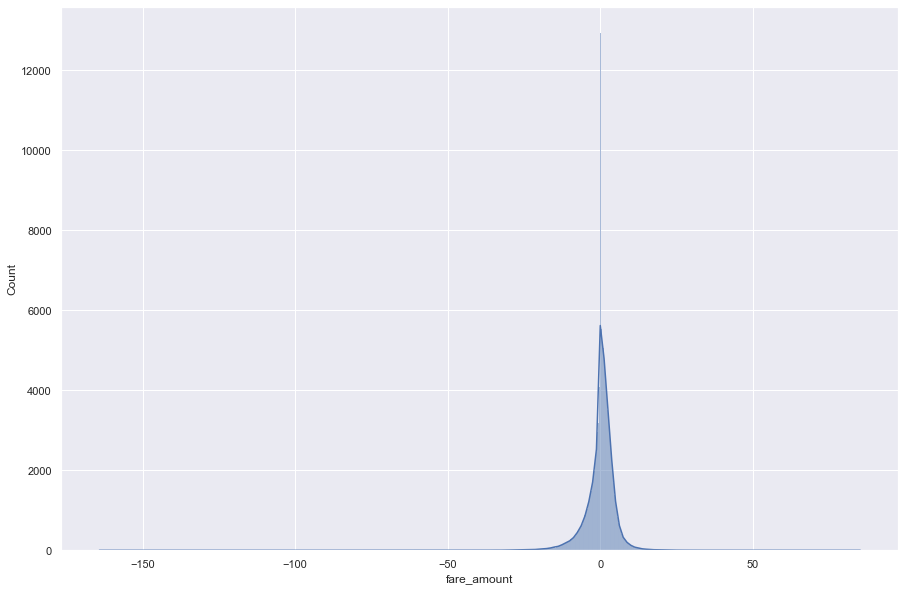

In [79]:
fig, ax = plt.subplots(1, 1, figsize = (15, 10))
sns.histplot(x=rf_error, kde=True)

Mean absolute error on test set is about 3.1. It seems to be reasonably good result. We can see that errors are almost normally distributed with center at 0. However, deviation in data is quite large.

### Neural network <a class="anchor" id="nn"></a>

Now, let's try neural network. We will use early stopping in order to (possisbly) decrease time of learning. We will also add some dropout layers to prevent overfitting.

In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [81]:
nn_model = tf.keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=(len(features), )),
    layers.Dropout(.1),
    layers.Dense(50, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(25, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(5, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1)
])

In [82]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               26900     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1

In [83]:
metrics = ['mae']
loss = ['mae']
optimizer = 'adagrad'

epochs = 50
batch_size = 32
validation_split = .2

early_stopping  = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True
)


In [84]:
nn_model.compile(
    metrics = metrics,
    optimizer=optimizer,
    loss=loss)

In [85]:
t0 = time.time()


history = nn_model.fit(
    X_train, y_train,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[early_stopping]
)


t1 = time.time()
print(f'Done in: {round((t1-t0)/2, 2)} min.')

Epoch 1/50
14759/14759 [==============================] - 35s 2ms/step - loss: 10.2275 - mae: 10.2275 - val_loss: 4.7217 - val_mae: 4.7217
Epoch 2/50
14759/14759 [==============================] - 30s 2ms/step - loss: 5.5197 - mae: 5.5197 - val_loss: 4.4723 - val_mae: 4.4723
Epoch 3/50
14759/14759 [==============================] - 30s 2ms/step - loss: 5.3277 - mae: 5.3277 - val_loss: 4.3654 - val_mae: 4.3654
Epoch 4/50
14759/14759 [==============================] - 31s 2ms/step - loss: 5.2547 - mae: 5.2547 - val_loss: 4.2908 - val_mae: 4.2908
Epoch 5/50
14759/14759 [==============================] - 30s 2ms/step - loss: 5.1779 - mae: 5.1779 - val_loss: 4.2134 - val_mae: 4.2134
Epoch 6/50
14759/14759 [==============================] - 30s 2ms/step - loss: 5.0974 - mae: 5.0974 - val_loss: 4.1587 - val_mae: 4.1587
Epoch 7/50
14759/14759 [==============================] - 30s 2ms/step - loss: 5.0329 - mae: 5.0329 - val_loss: 4.1061 - val_mae: 4.1061
Epoch 8/50
14759/14759 [===============

Now let's plot history of learning.

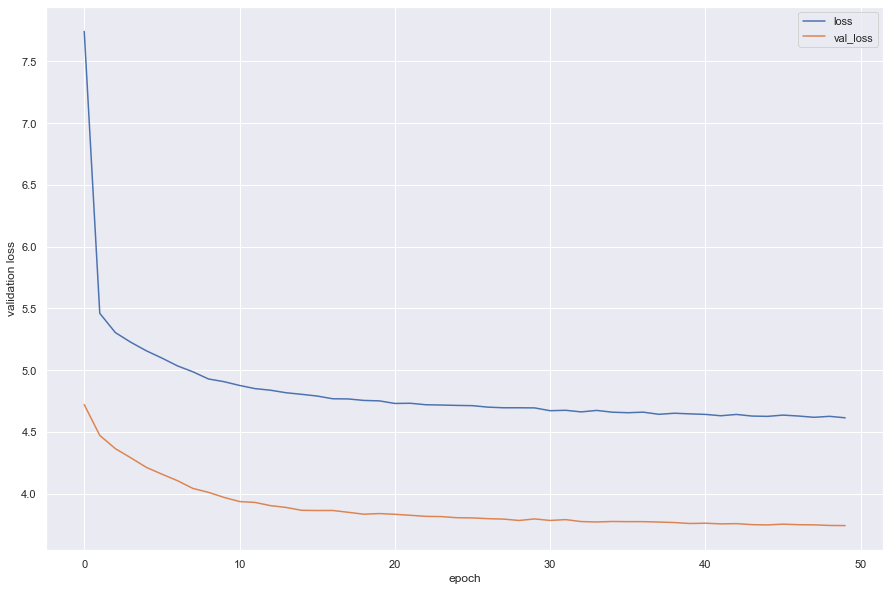

In [86]:
plot_loss(history)

We can see that validation error decreases and stabilize. It seems that model is not overfitted.

So let's make some predictions. Similarly to random forest, we will plot histogram for errors.

In [87]:
nn_prediction = nn_model.predict(X_test)

In [88]:
nn_prediction = nn_prediction.reshape(-1,)

In [89]:
nn_mae = mean_absolute_error(y_test, nn_prediction)
print(f'Neural network MAE: {nn_mae}')

Neural network MAE: 3.733925584966853


<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

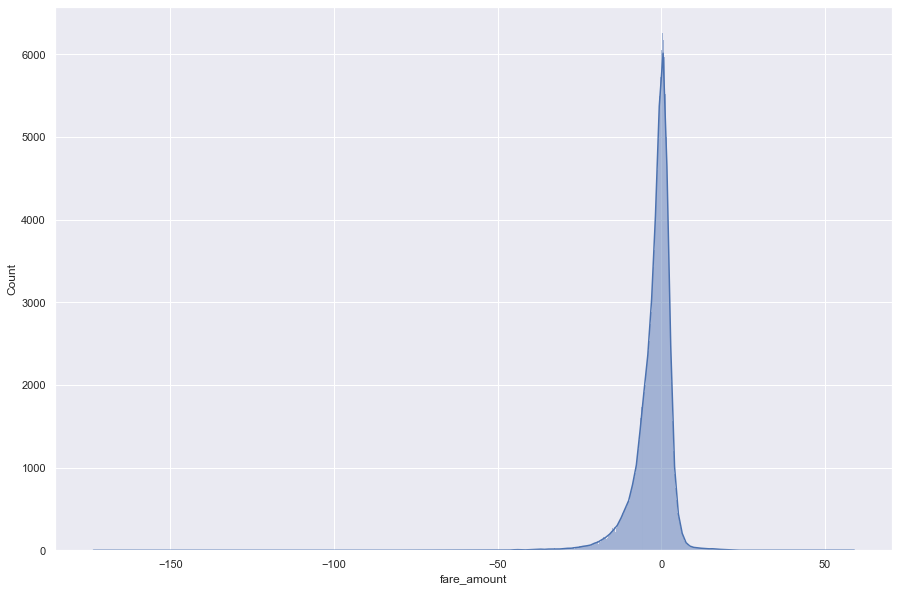

In [90]:
nn_error = nn_prediction - y_test

fig, ax = plt.subplots(1, 1, figsize = (15, 10))
sns.histplot(x=nn_error, kde=True)

Score for neural network (3.7) is a bit worse than for random forest (3.1). Also histogram of errors is shifted and skewed. It seems that random forest was better trained. However, one has to take into account that neural network learning was way shorter.

### Save models

We can save our models using `pickle` packages.

In [91]:
import pickle

In [111]:
rf_model_path = 'models/rf_model/rf_model.pickle'

nn_model_path = 'models/nn_model/nn_model.h5'
nn_model_history_path = 'models/nn_model/history.pickle'

In [112]:
# save rf_model
with open(rf_model_path, 'wb') as f:
    pickle.dump(rf_best, f)

# save nn_model and its history
with open(nn_model_history_path, 'wb') as f:
    pickle.dump(history.history, f)
nn_model.save(nn_model_path)

In [115]:
# wczytanie modeli
# with open(rf_model_path, 'rb') as f:
#     rf_model_loaded = pickle.load(f)
    
# nn_model_loaded = tf.keras.models.load_model(nn_model_path)

# Summary and recomedations <a class="anchor" id="summary"></a>

**Summary** \
In this notebook we tried to get some informations about yellow taxi trips in New York City.

Some conclusions that can be made are:
- Manhattan is popular destination. Wheter one starts in Manhattan, Queens or Brooklyn, there is high chance he will ends in Manhattan
- trips in Manhattan are relatively short. As a result fare amount by mile is high. It creates possibilities for higher income
- on the other hand, trips that starts in Queens are usually longer and, as a result, more expensive
- morning hours are best in terms of average fare amount
- trips with negotiated fare might be better paid than standard one

We also build some models to predict fare amount on the basis of time and pick-up location. It may be helpful for proper cars distribution.

\
\
**Recomendations** \
Still, there are many things that can be done, for example:
- deeper analysis
    - we mostly focused on boroughts. One can dig deeper and check some behaviors in zones
    - more analysis should be done in terms of time, for example workday/weekend/holidays
    - more analysis in terms of `ratecodeid`. Detailed check if negotiated fare is indeed higher than standard one. If it is the case then what are pick-up zones with high probability of getting such trips
- modelling:
    - after deeper analysis some new dependecies might be noticed and included into model
    - more parameters might be tested
    - models can be fed with more data
    - features importance should be performed
    - deeper analysis of the models results


# Appendix <a class="anchor" id="aux"></a>

In [27]:
def plot_loss(history):
    fig, ax = plt.subplots(1, 1, figsize = (15, 10))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('validation loss')
    plt.legend()
    plt.grid(True)

In [28]:
def borough_map(title, df, ax,
                x_lim = None, 
                y_lim = None, 
                show_labels=True,
                labels=None):
    '''
    Plot map with lim coordinates
    '''
    
    borough_ids = {f'{borough}': list(df.loc[df.borough == borough].index) for borough in df['borough'].unique()}
    borough_colors = {'EWR': 'green', 
                      'Queens': 'red', 
                      'Bronx': 'grey', 
                      'Manhattan': 'purple', 
                      'Staten Island': 'orange', 
                      'Brooklyn': 'blue'}
    
   
    for coord in df['coords']:
        x = [i[0] for i in coord]
        y = [i[1] for i in coord]
        ax.plot(x, y, 'k')
    
    for borough_name, zone_ids in borough_ids.items():
        coords = df.loc[df['borough'] == borough_name, 'coords']
        coords = list(itertools.chain.from_iterable(coords))
        
        for zone_id in zone_ids:
            coord = df.loc[zone_id, 'coords']
            x_lon = [i[0] for i in coord]
            y_lat = [i[1] for i in coord]
            ax.fill(x_lon,y_lat, borough_colors[borough_name], alpha=0.25)
            
        x0 = np.mean([c[0] for c in coords])
        y0 = np.mean([c[1] for c in coords])
        if show_labels:
            if labels is not None and labels.get(borough_name) is not None:
                text = borough_name + f'\n{labels.get(borough_name)}'
            else:
                text = borough_name
            ax.text(x0, y0, text, bbox=dict(facecolor='black', alpha=0.75), color="white", fontsize=15)
    
    if (x_lim != None) & (y_lim != None):     
        ax.xlim(x_lim)
        ax.ylim(y_lim)
        
    ax.set_title(title)

In [29]:
def simple_box_plot_and_hisotgram(data, column, figsize=(15, 5), 
                                  discrete=False,
                                  kde=True,
                                  bins='auto'):
    """ Plot box plot and histogram for selected colum """
    
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    sns.boxplot(ax=axs[0], x=column, data=data)
    sns.histplot(ax=axs[1], x=column, data=data, discrete=discrete, kde=kde)

    axs[0].tick_params(axis='x', labelrotation=45)
    axs[1].tick_params(axis='x', labelrotation=45)
    
    fig.suptitle(column, fontsize=16)
    plt.show()

    return None